## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Импорт библиотек </h1>

In [1]:
# !pip install bayesian-optimization


In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import warnings

from tensorflow.keras import layers, models, optimizers, Input
from tensorflow.keras.optimizers import Adam
from bayes_opt import BayesianOptimization


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Функции </h1>  

In [10]:
# Подготовка изображений
def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0  # Нормализация для 8-битовых изображений
    return image, label

# Отображение примеров изображений
def display_sample_images(dataset, class_name, n=7):
    plt.rcParams.update({'axes.grid': False})
    plt.figure(figsize=(15, 15))
    for images, labels in dataset.take(1):  # Берем одну партию данных
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            plt.imshow(images[i].numpy())
            plt.title(class_name)
            plt.axis("off")
    plt.show()

# Функция для отображения распределения классов
def plot_class_distribution(dataset):
    class_counts = dataset.map(lambda img, label: label).batch(1)
    class_counts = class_counts.flat_map(lambda label: tf.data.Dataset.from_tensor_slices(label))
    class_counts = class_counts.reduce(tf.zeros(len(class_names), dtype=tf.int64), lambda x, _: x + 1)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(class_names)), class_counts.numpy())
    plt.xticks(range(len(class_names)), class_names)
    plt.xlabel('')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution')
    plt.show()

# Функция для аугментации изображений
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # Отражение по горизонтали
    image = tf.image.random_brightness(image, max_delta=0.2)  # Изменение яркости
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Изменение контрастности
    image = tf.image.rot90(image, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))  #Случайные повороты
    return image, label

# Функция для добавления шума
def add_noise(image, label):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05, dtype=tf.float32)
    image = image + noise
    return image, label

# Разделение датасета на обучающую и тестовую выборки
def split_dataset(dataset, split_ratio=0.8):
    dataset = dataset.shuffle(buffer_size=1000)  # Перемешиваем для случайного распределения
    dataset_size = sum(1 for _ in dataset)  # Подсчитываем количество элементов
    train_size = int(split_ratio * dataset_size)
    # take(n) возвращает новый датасет, содержащий первые n элементов
    train_dataset = dataset.take(train_size).batch(batch_size)
    # skip(n) возвращает новый датасет, пропуская первые n элементов
    test_dataset = dataset.skip(train_size).batch(batch_size)
    return train_dataset, test_dataset


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Загрузка данных</h1>

In [4]:
dataset, metadata = tfds.load('tf_flowers', with_info=True, as_supervised=True)
train_dataset = dataset['train']
class_names = metadata.features['label'].names
print(class_names)


['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']


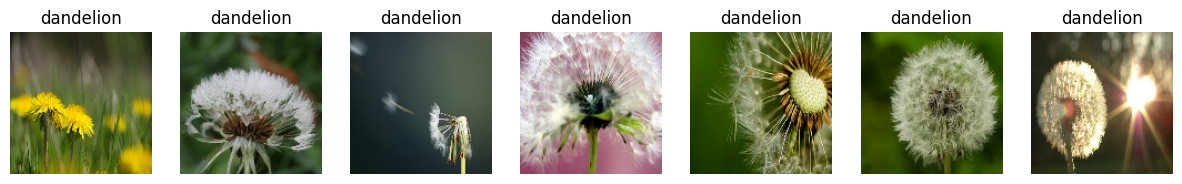

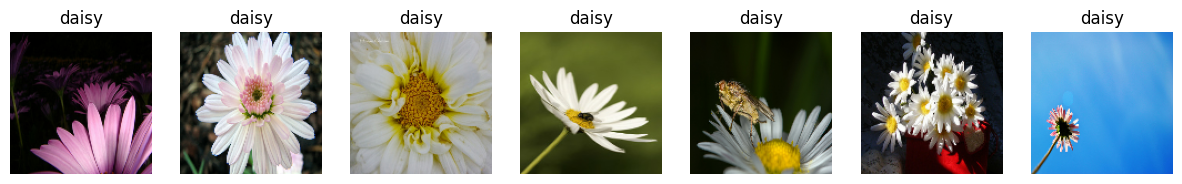

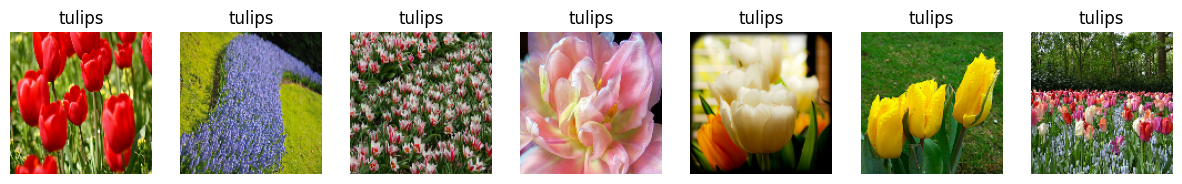

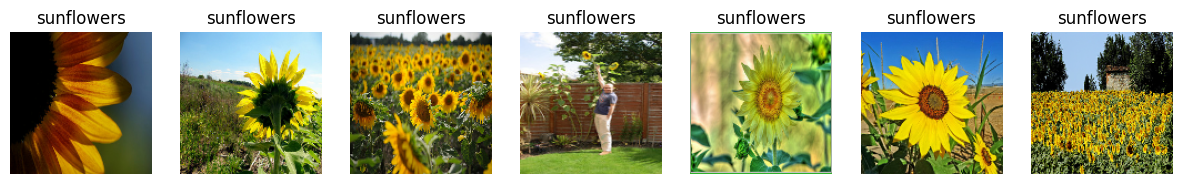

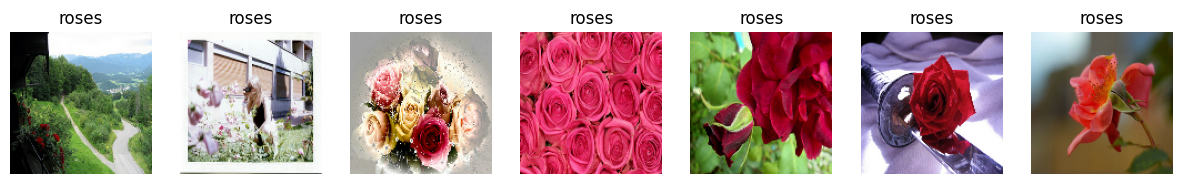

In [5]:
for class_name in class_names:
    target_class_index = class_names.index(class_name)
    filtered_dataset = train_dataset.filter(lambda image, label: label == target_class_index)
    display_sample_images(filtered_dataset.map(preprocess).batch(32), class_name)



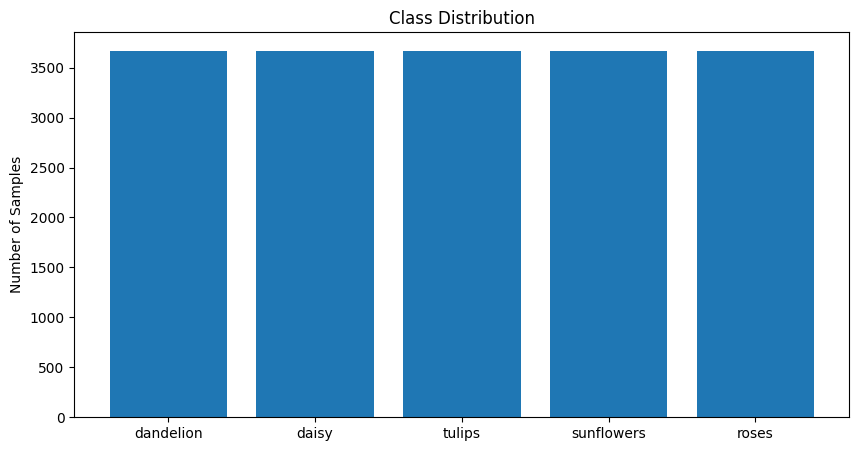

In [6]:
# Отображение изображений и распределения классов
plot_class_distribution(train_dataset)


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Преобразование и подготовка данных</h1>

In [7]:
# Преобразование меток классов
# Каждый класс получит свою метку, например: 0 для первого, 1 для второго и т.д.
train_datasets = []
for class_index, class_name in enumerate(class_names):
    class_dataset = train_dataset.filter(lambda img, label: label == class_index)
    class_dataset = class_dataset.map(lambda img, _: (img, class_index))
    train_datasets.append(class_dataset)

# Применим аугментацию и преобразование для каждого класса
train_datasets = [ds.map(augment) for ds in train_datasets]

# Объединим датасеты с балансировкой
dataset = tf.data.Dataset.sample_from_datasets(train_datasets, weights=[1/len(train_datasets)] * len(train_datasets))

# Стандартизируем размеры изображений и проведём нормализацию
dataset = dataset.map(preprocess)

# Добавим на изобарежния небольшое количество шума
dataset = dataset.map(add_noise)

# Перемешивание данных
dataset = dataset.shuffle(1000)

# Посмотрим на получившиеся изображения
for class_index, class_name in enumerate(class_names):
    class_dataset_after = dataset.filter(lambda img, label: label == class_index)
    print(f"Sample images for '{class_name}':")
    display_sample_images(class_dataset_after.batch(32), class_name)


Output hidden; open in https://colab.research.google.com to view.

In [9]:
batch_size = 32

train_dataset, test_dataset = split_dataset(dataset)

num_train_batches = sum(1 for _ in train_dataset)
num_test_batches = sum(1 for _ in test_dataset)

print(f'Количество обучающих батчей: {num_train_batches}')
print(f'Количество тестовых батчей: {num_test_batches}')


Количество обучающих батчей: 92
Количество тестовых батчей: 23


## <h1 id="aa" style="color:white;background:#B00000;padding:8px;border-radius:8px;font-family:newtimeroman;"> Обучение моделей</h1>

### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Baseline</h1>

/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
     92/Unknown 30s 167ms/step - accuracy: 0.2600 - loss: 5.6980

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


92/92 ━━━━━━━━━━━━━━━━━━━━ 48s 361ms/step - accuracy: 0.2604 - loss: 5.6767 - val_accuracy: 0.3406 - val_loss: 1.6936
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 332ms/step - accuracy: 0.4048 - loss: 1.5979 - val_accuracy: 0.4264 - val_loss: 1.7584
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 46s 406ms/step - accuracy: 0.3757 - loss: 2.1089 - val_accuracy: 0.3706 - val_loss: 1.6854
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 74s 335ms/step - accuracy: 0.3465 - loss: 2.0620 - val_accuracy: 0.3787 - val_loss: 2.1821
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 319ms/step - accuracy: 0.3657 - loss: 1.8824 - val_accuracy: 0.4646 - val_loss: 1.3395
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 301ms/step - accuracy: 0.4299 - loss: 1.4199 - val_accuracy: 0.3624 - val_loss: 1.6887
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 36s 301ms/step - accuracy: 0.3942 - loss: 1.5322 - val_accuracy: 0.3815 - val_loss: 1.6089
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 38s 342ms/step - accuracy: 0.4397 - loss: 1.3954 - val_accuracy: 0.442

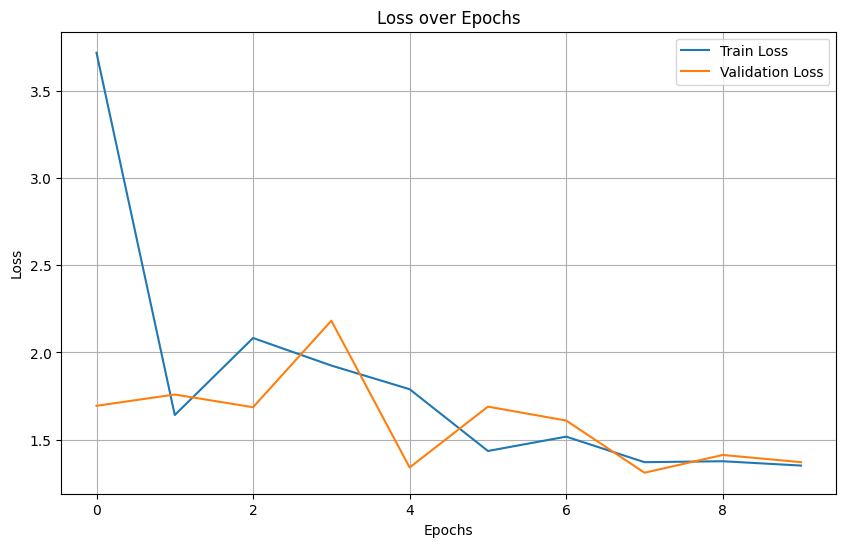

In [12]:
model = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),  # Преобразует входные данные в одномерный вектор
    layers.Dense(128, activation='relu'),       # Первый скрытый слой с 128 нейронами и ReLU активацией
    layers.Dense(64, activation='relu'),        # Второй скрытый слой с 64 нейронами и ReLU активацией
    layers.Dense(len(class_names), activation='softmax')  # Выходной слой с количеством нейронов = количеству классов
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

train_loss, train_accuracy = model.evaluate(train_dataset)
print(f'Train\n Loss: {train_loss:.3f}, Accuracy: {train_accuracy:.3f}')
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test\n Loss: {test_loss:.3f}, Accuracy: {test_accuracy:.3f}')

# Визуализация потерь
train_loss_values = history.history['loss']
val_loss_values = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Подбор гиперапарметров через BayesianOptimization</h1>

In [14]:
def train_evaluate_model(neurons1, neurons2, learning_rate):
    model = models.Sequential([
        Input(shape=(128, 128, 3)),                 # Входные данные размером 128x128 с 3 каналами
        layers.Flatten(),                           # Преобразование данных в одномерный вектор
        layers.Dense(int(neurons1), activation='relu'),  # Первый скрытый слой
        layers.Dense(int(neurons2), activation='relu'),  # Второй скрытый слой
        layers.Dense(len(class_names), activation='softmax')  # Выходной слой для многоклассовой классификации
    ])

    # Оптимизатор
    optimizer = optimizers.Adam(learning_rate=learning_rate)

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',  # Для многоклассовой классификации
                  metrics=['accuracy'])

    # Тренировка модели
    history = model.fit(train_dataset, epochs=4, verbose=0)  # Сокращённое количество эпох для скорости

    # Оценка модели на тестовой выборке
    loss, accuracy = model.evaluate(test_dataset, verbose=0)
    return accuracy

# Диапазоны для гиперпараметров
pbounds = {
    'neurons1': (64, 256),         # Диапазон для количества нейронов в первом слое
    'neurons2': (32, 128),         # Диапазон для количества нейронов во втором слое
    'learning_rate': (1e-5, 1e-2)  # Диапазон для скорости обучения
}

optimizer = BayesianOptimization(
    f=train_evaluate_model,
    pbounds=pbounds,
    verbose=2,  # Вывод всех шагов
    random_state=1
)

optimizer.maximize(init_points=5, n_iter=10)

best_params = optimizer.max['params']
print(f"Best parameters: {best_params}")

neurons1_best = int(best_params['neurons1'])
neurons2_best = int(best_params['neurons2'])
learning_rate_best = best_params['learning_rate']

print(f"Best Neurons 1: {neurons1_best}, Best Neurons 2: {neurons2_best}, Best Learning Rate: {learning_rate_best}")


|   iter    |  target   | learni... | neurons1  | neurons2  |
-------------------------------------------------------------
| 1         | 0.3038    | 0.004176  | 202.3     | 32.01     |
| 2         | 0.3256    | 0.00303   | 92.18     | 40.86     |
| 3         | 0.4223    | 0.001871  | 130.3     | 70.09     |
| 4         | 0.3828    | 0.005393  | 144.5     | 97.78     |
| 5         | 0.2752    | 0.002052  | 232.6     | 34.63     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 6         | 0.4305    | 0.0003728 | 130.4     | 69.05     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 7         | 0.3556    | 0.006711  | 135.5     | 57.85     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 8         | 0.4591    | 1e-05     | 123.4     | 65.49     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 9         | 0.4823    | 1e-05     | 112.1     | 66.91     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 10        | 0.4523    | 1e-05     | 107.1     | 77.43     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 11        | 0.3025    | 0.01      | 99.05     | 66.37     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 12        | 0.4646    | 1e-05     | 116.3     | 74.32     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 13        | 0.4482    | 1e-05     | 111.1     | 90.46     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 14        | 0.4673    | 1e-05     | 97.14     | 95.29     |


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


| 15        | 0.3787    | 0.00937   | 104.2     | 107.0     |
Best parameters: {'learning_rate': 1e-05, 'neurons1': 112.09081588280439, 'neurons2': 66.91137161401522}
Best Neurons 1: 112, Best Neurons 2: 66, Best Learning Rate: 1e-05


### <h1 id="aa" style="color:white;background:#42aaff;padding:8px;border-radius:8px;font-family:newtimeroman;"> Нейросеть с наилучшими гиперпараметрами</h1>

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 45s 366ms/step - accuracy: 0.3070 - loss: 1.5659 - val_accuracy: 0.3910 - val_loss: 1.4058
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 73s 296ms/step - accuracy: 0.4031 - loss: 1.3758 - val_accuracy: 0.4237 - val_loss: 1.3678
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.4101 - loss: 1.3430 - val_accuracy: 0.4414 - val_loss: 1.2780
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 288ms/step - accuracy: 0.4179 - loss: 1.3214 - val_accuracy: 0.4251 - val_loss: 1.2924
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 297ms/step - accuracy: 0.4189 - loss: 1.3341 - val_accuracy: 0.4455 - val_loss: 1.2880
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 295ms/step - accuracy: 0.4285 - loss: 1.2800 - val_accuracy: 0.4864 - val_loss: 1.2193
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 283ms/step - accuracy: 0.4498 - loss: 1.2801 - val_accuracy: 0.4564 - val_loss: 1.2595
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 47s 352ms/step - accuracy: 0.4252 - loss: 1.2735 - val_accuracy: 0.461

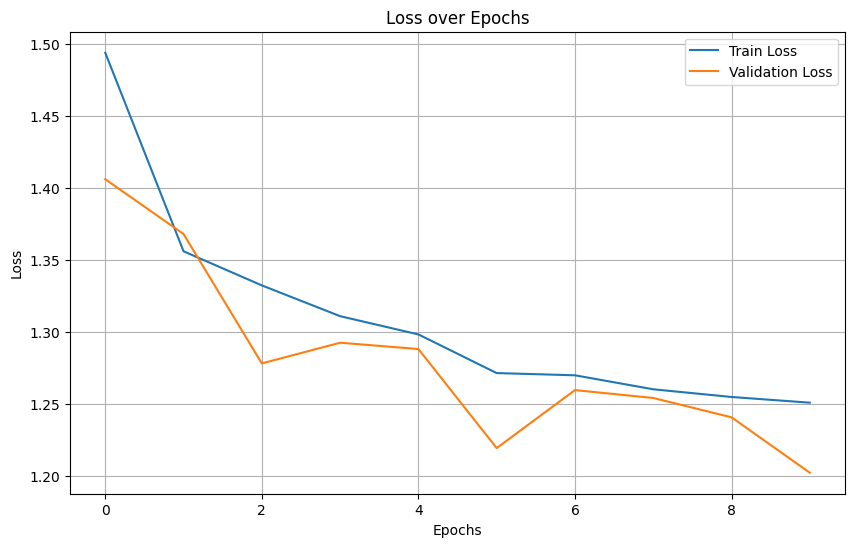

In [15]:
best_params = optimizer.max['params']
neurons1 = int(best_params['neurons1'])
neurons2 = int(best_params['neurons2'])
learning_rate = best_params['learning_rate']

model_best = models.Sequential([
    layers.Flatten(input_shape=(128, 128, 3)),
    layers.Dense(neurons1, activation='relu'),
    layers.Dense(neurons2, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
optimizer_best = optimizers.Adam(learning_rate=learning_rate)
model_best.compile(optimizer=optimizer_best,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

history_best = model_best.fit(train_dataset, epochs=10, validation_data=test_dataset, verbose=1)

train_loss_best, train_accuracy_best = model_best.evaluate(train_dataset)
print(f'Train with best parameters\n Loss: {train_loss_best:.3f}, Accuracy: {train_accuracy_best:.3f}')
test_loss_best, test_accuracy_best = model_best.evaluate(test_dataset)
print(f'Test with best parameters\n Loss: {test_loss_best:.3f}, Accuracy: {test_accuracy_best:.3f}')

train_loss_values = history_best.history['loss']
val_loss_values = history_best.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
